In [1]:
# general
import os
import sys
import time
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Numpyro
import numpyro
import numpyro.distributions as npdist
import random as rnd
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
from numpyro.diagnostics import hpdi

numpyro.set_host_device_count(4)

#JAX
import jax
from jax import random
import jax.numpy as jnp

# check versions
print(numpyro.__version__)
print(jax.__version__)
print(torch.__version__)
from platform import python_version
print(python_version())

import dill

import geopandas as gpd

# Weights and Biases
import wandb
wandb.login()

0.10.1
0.3.25
1.12.1
3.8.16


wandb: Currently logged in as: elizaveta-p-semenova (test_wnb). Use `wandb login --relogin` to force relogin


True

In [2]:
# set device
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [94]:
args = {"seed": 0,
        
        # architecture
        #"conditional": True,   # CVAE if True, VAE otherwise
        #"input_dim": 63,
        #"hidden_dim": 63,
        #"z_dim": 50,
        
        # data generation
        "new_data": False,      # set to True to generate new data. Otherwise read from file
        "save_data": False,     # set to True to save generated training and test datasets
        #"samples": 100000,
        
        # VAE setup
        #"vae_sd": 0.8, 
        #"n_epochs": 400,      
        #"batch_size": 1000,
        #"learning_rate": 1e-3,
        "train_vae": False,      # set to True to train VAE
        "save_vae": False,
        "load_vae": True,      # set to True to load trained CVAE
        "print_loss": True,
        
        # MCMC setup
        "mcmc_run": True,
        "mcmc_save": False,
        "num_warmup": 2000,
        "num_samples": 10000,
        "num_chains": 2,
        "thinning": 1
       }

In [4]:
config = {
    "conditional": True,   # CVAE if True, VAE otherwise
    "input_dim": 63,
    "hidden_dim": 63,
    "z_dim": 50,
    "samples": 100000,
    "vae_sd": 0.8, 
    "n_epochs": 10000,      
    "batch_size": 1000,
    "learning_rate": 1e-3,
}

## Data

In [5]:
os.getcwd()

'/Users/es/Dropbox/00 Oxford/39_CVAE/PyTorch/Python'

(63, 31)


<AxesSubplot: >

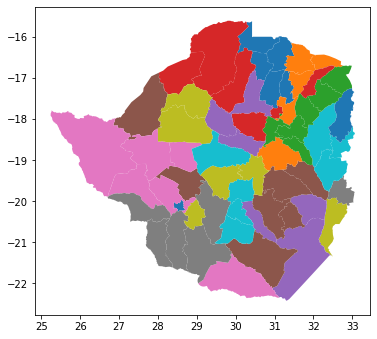

In [6]:
s = gpd.read_file("data/Zimbabwe/zwe2016phia.geojson")
print(s.shape)

fig, ax = plt.subplots(1, 1, figsize=(6,6))
s.plot(column='area_id', ax=ax, legend=False)

In [7]:
s = s[['area_id', 'geometry', 'y', 'n_obs', 'estimate']]
s['y'] = round(s['y']).astype(int)
s['n_obs'] = round(s['n_obs']).astype(int)
s["centroid"] = s["geometry"].centroid
print(np.sum(np.isnan(s['n_obs'])))
print(s.shape)
s.head()

/opt/anaconda3/envs/numpyro10_torch/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


0
(63, 6)


/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_45488/2991311570.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  s["centroid"] = s["geometry"].centroid
/opt/anaconda3/envs/numpyro10_torch/lib/python3.8/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


,area_id,geometry,y,n_obs,estimate,centroid
0,ZWE_2_1,"MULTIPOLYGON (((28.60837 -20.23077, 28.60534 -...",250,1520,0.164841,POINT (28.55557 -20.12184)
1,ZWE_2_2,"MULTIPOLYGON (((30.99973 -17.99862, 31.00954 -...",44,280,0.155943,POINT (31.06270 -18.01409)
2,ZWE_2_3,"MULTIPOLYGON (((31.13664 -17.92887, 31.13584 -...",148,1243,0.119002,POINT (31.04900 -17.83975)
3,ZWE_2_4,"MULTIPOLYGON (((31.72304 -19.02447, 31.73064 -...",28,265,0.105219,POINT (31.86831 -19.44905)
4,ZWE_2_5,"MULTIPOLYGON (((32.87748 -20.09961, 32.85814 -...",10,118,0.086011,POINT (32.72163 -19.78411)


<AxesSubplot: >

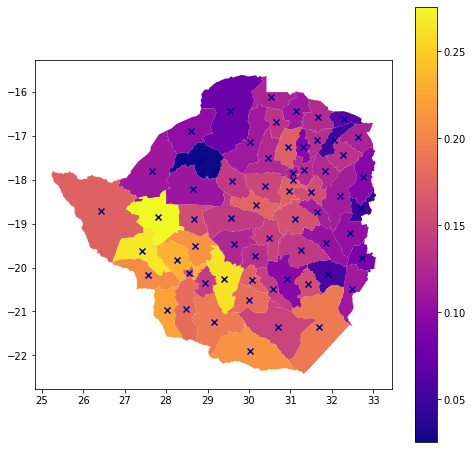

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8,8))
#divider = make_axes_locatable(ax)
s.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
s["centroid"].plot(ax=ax, color="DarkBlue", marker="x")

## GP priors

In [9]:
# functions implementing GP priors, which are generalisable for any number of dimensions

def dist_euclid(x, z):
    x = jnp.array(x) 
    z = jnp.array(z)
    if len(x.shape)==1:
        x = x.reshape(x.shape[0], 1)
    if len(z.shape)==1:
        z = z.reshape(z.shape[0], 1)
    n_x, m = x.shape
    n_z, m_z = z.shape
    assert m == m_z
    delta = jnp.zeros((n_x,n_z))
    for d in jnp.arange(m):
        x_d = x[:,d]
        z_d = z[:,d]
        delta += (x_d[:,jnp.newaxis] - z_d)**2
    return jnp.sqrt(delta)

def exp_sq_kernel(x, z, var, length, noise=0, jitter=1.0e-5):
    dist = dist_euclid(x, z)
    deltaXsq = jnp.power(dist/ length, 2.0)
    k = var * jnp.exp(-0.5 * deltaXsq)
    k += (noise + jitter) * jnp.eye(x.shape[0])
    return k

# Prevalence model - centroids

In [95]:
def prev_model_centroids(x, n_obs=None, length=None, var=1, jitter=1.0e-5, gp_kernel=exp_sq_kernel, y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
    
    if length==None:  
        length = numpyro.sample("length", npdist.Gamma(2,4)) 
    
    k = gp_kernel(x, x, var, length, jitter)
    
    kernel_var = numpyro.sample("kernel_var", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # linear predictor
    lp = b0 + re
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [96]:
#temp_centroids = s["geometry"].to_crs("EPSG:32735").centroid
temp_centroids = s["geometry"].centroid
centroids = gpd.GeoDataFrame()
centroids["x"] = temp_centroids.geometry.apply(lambda x: x.x)
centroids["y"] = temp_centroids.geometry.apply(lambda x: x.y)
x_coords = jnp.array(centroids["x"])
y_coords = jnp.array(centroids["y"])
coords = jnp.dstack((x_coords, y_coords))[0]
coords.shape
coords[0:10,:]

/var/folders/q3/n2z18__9281b8xfhctcpxfsr0000gn/T/ipykernel_45488/258168673.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = s["geometry"].centroid


DeviceArray([[ 28.555567, -20.121845],
             [ 31.062702, -18.014091],
             [ 31.048996, -17.839746],
             [ 31.868307, -19.44905 ],
             [ 32.721634, -19.784111],
             [ 32.474644, -20.495062],
             [ 32.182587, -18.362677],
             [ 32.43056 , -19.223494],
             [ 32.708965, -18.639462],
             [ 32.75779 , -17.937792]], dtype=float32)

## Prior predictive

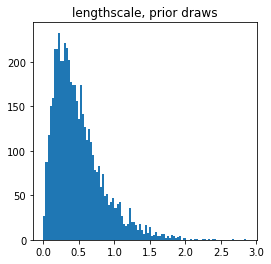

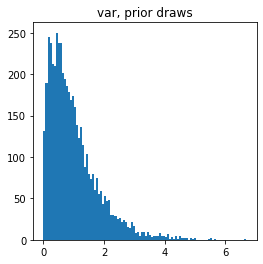

In [97]:
rng_key, rng_key_ = random.split(random.PRNGKey(4))
gp_predictive = Predictive(prev_model_centroids, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=jnp.array(coords), n_obs = jnp.array(s.n_obs))

ls_prior_draws = gp_preds['length']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['kernel_var']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

Text(0.5, 1.0, 'Prior max')

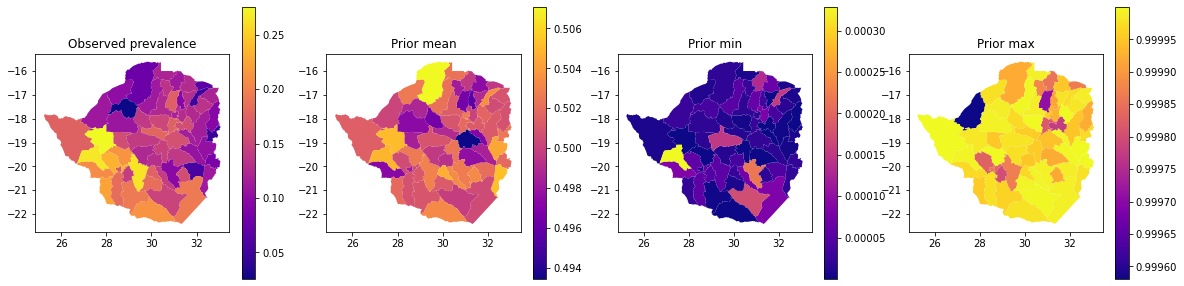

In [98]:
prior_theta = gp_preds['theta']

prior_theta_mean = prior_theta.mean(axis=0)
prior_theta_min = prior_theta.min(axis=0)
prior_theta_max = prior_theta.max(axis=0)

s['prior_theta_mean'] = prior_theta_mean
s['prior_theta_min'] = prior_theta_min
s['prior_theta_max'] = prior_theta_max

theta_observed = s['estimate']

_max = np.max([theta_observed, prior_theta_max])
_min = np.min([theta_observed, prior_theta_min])

fig, ax = plt.subplots(1, 4, figsize=(20,5))

s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_mean", ax=ax[1], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_min", ax=ax[2], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)
s.plot(column="prior_theta_max", ax=ax[3], legend=True, cmap='plasma')#, vmin=_min, vmax =_max)

ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Prior mean')
ax[2].set_title( 'Prior min')
ax[3].set_title( 'Prior max')

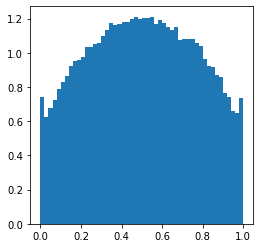

In [99]:
prior_theta_long = prior_theta.reshape(-1)
plt.hist(prior_theta_long, density=True, bins=50)
plt.show()

## Inference

In [100]:
fname = 'mcmc/Zimbabwe_gp' + '_niter' + str(args["num_samples"] + args["num_warmup"]) + '.pkl'
print(fname)

if args["mcmc_run"] == True:
    rng_key, rng_key_predict = random.split(random.PRNGKey(4))

    # inference
    start = time.time()
    kernel = NUTS(prev_model_centroids)
    mcmc_gp = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_samples'], num_chains=args["num_chains"])
    mcmc_gp.run(rng_key, x=jnp.array(coords), n_obs = jnp.array(s.n_obs), y = jnp.array(s.y))
    t_elapsed = time.time() - start
    
    if args["mcmc_save"] == True:
        with open(fname, 'wb') as f:
            dill.dump(mcmc_gp, f)
        print("saved MCMC results")    

else:
    with open(fname, 'rb') as f:
        mcmc_gp = dill.load(f)
    print("loaded MCMC results")    
        

mcmc/Zimbabwe_gp_niter12000.pkl


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [101]:
prev_samples_gp = mcmc_gp.get_samples()
mcmc_gp.print_summary(exclude_deterministic=False)
mcmc_gp_samples = mcmc_gp.get_samples()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          b0     -1.79      0.15     -1.80     -2.04     -1.56    819.92      1.00
  kernel_var      0.40      0.10      0.38      0.25      0.54    421.83      1.00
      length      1.02      0.27      0.97      0.61      1.42    116.87      1.01
       re[0]      0.24      0.17      0.24     -0.02      0.51    951.87      1.00
       re[1]     -0.02      0.16     -0.02     -0.27      0.24    917.07      1.00
       re[2]     -0.05      0.16     -0.05     -0.31      0.21    908.46      1.00
       re[3]     -0.30      0.19     -0.30     -0.60      0.02   1197.20      1.00
       re[4]     -0.48      0.22     -0.47     -0.82     -0.11   1646.46      1.00
       re[5]     -0.26      0.20     -0.25     -0.57      0.07   1527.20      1.00
       re[6]     -0.27      0.18     -0.27     -0.56      0.03   1051.87      1.00
       re[7]     -0.45      0.19     -0.44     -0.76     -0.14   1248.67      1.00
   

In [108]:
if args["mcmc_run"] == True:
    print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = np.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 494 s
Average ESS for all REs : 1168


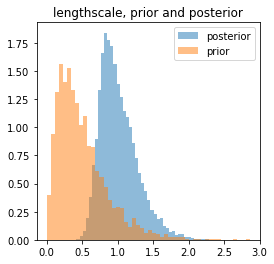

In [109]:
c_samps_gp = mcmc_gp_samples['length']
plt.hist(c_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('lengthscale, prior and posterior')
plt.legend()

(0.0, 3.0)

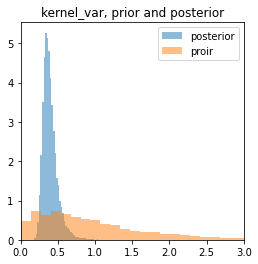

In [110]:
var_samps_gp = mcmc_gp_samples['kernel_var']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'proir', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

Text(0.5, 1.0, 'Estimated prevalence (GP centroids)')

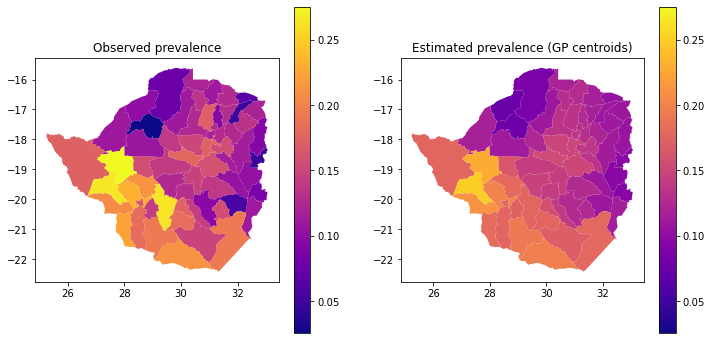

In [111]:
# posterior predictive
prev_posterior_predictive = Predictive(prev_model_centroids, prev_samples_gp)(random.PRNGKey(1), x=jnp.array(coords), n_obs = jnp.array(s.n_obs))


theta_samps_gp = prev_posterior_predictive['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = np.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = np.quantile(theta_samps_gp, 0.75, axis=0)

s['theta_gp'] = theta_mean_gp

theta_observed = s['estimate']
theta_estimated_gp = s['theta_gp']

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_gp", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (GP centroids)')

Text(0, 0.5, 'CAR estimated theta')

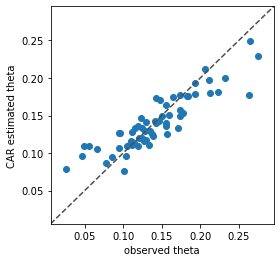

In [112]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(theta_observed, theta_estimated_gp)
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("observed theta")
plt.ylabel("CAR estimated theta")

In [113]:
#fname = 'mcmc/Zimbabwe_gp' + '_niter' + str(args["num_samples"] + args["num_warmup"]) + '.pkl'
#print(fname)

#import dill
#with open(fname, 'wb') as f:
#    dill.dump(mcmc_gp, f)

#with open(fname, 'rb') as f:
#    mcmc = dill.load(f)

## Train VAE

## Generate data - GP priors

In [114]:
def model_gp_draws(x, jitter=1.0e-5, var = 1, gp_kernel=exp_sq_kernel, length=None):
    
    if length==None:  
        length_draw = numpyro.sample("length_draw", npdist.Gamma(2,4)) 
        length = numpyro.deterministic("length", jnp.array([length_draw]))
    
    k = gp_kernel(x, x, var, length, jitter)
    
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))

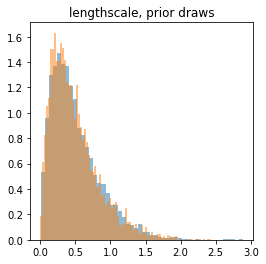

In [115]:
rng_key, rng_key_ = random.split(random.PRNGKey(5))
gp_short_predictive = Predictive(model_gp_draws, num_samples=5000)
gp_short_preds = gp_short_predictive(rng_key_, x=jnp.array(coords))

gp_short_draws = gp_short_preds['length'][:,0]
plt.hist(gp_short_draws, bins=50, alpha=0.5, label='short', density=True)
plt.hist(ls_prior_draws, bins=100, alpha=0.5, label='gp', density=True)
plt.title('lengthscale, prior draws')
plt.show()

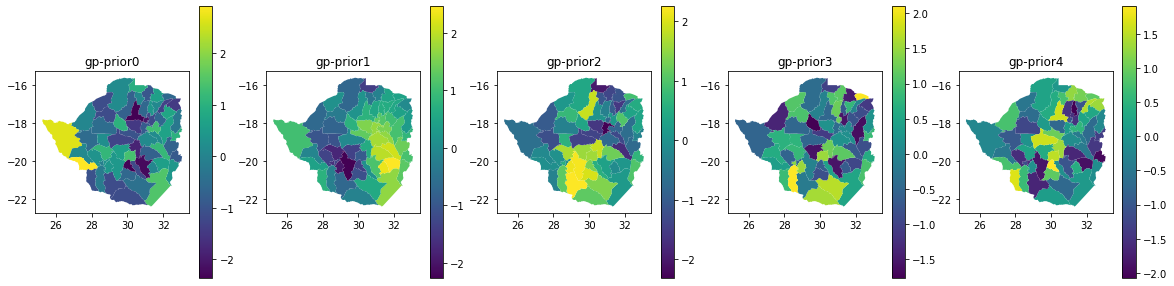

In [116]:
# gp: prior predictive
rng_key, rng_key_ = random.split(random.PRNGKey(4))
gp_predictive = Predictive(model_gp_draws, num_samples=5)
gp_preds = gp_predictive(rng_key_, x=jnp.array(coords))
gp_draws = gp_preds['re_std']

s_plot = s.copy()
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_draw_' + str(i)
    s_plot[nm] = gp_draws[i,:]
    s_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'gp-prior' + str(i))

In [117]:
class GP1D(Dataset):
    def __init__(self, n_samples=10000, coords=coords, length=None): 
        self.n_samples = n_samples
        self.coords = coords
        self.length = length
        self.gp_draws, self.length = self.__simulatedata__()
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx=0):
        return(self.gp_draws[idx], self.length[idx])

    def __simulatedata__(self):
        rng_key = rnd.randint(0, 912393890428)
        rng_key, _ = random.split(random.PRNGKey(rng_key))

        gp_predictive = Predictive(model_gp_draws, num_samples=self.n_samples)
        all_draws = gp_predictive(rng_key, x=jnp.array(coords), length=self.length)

        length_draws = np.array(all_draws['length'])
        gp_draws = np.array(all_draws['re_std'])
        
        return (gp_draws, length_draws)

(0.0, 3.0)

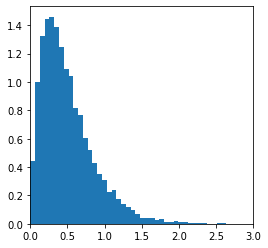

In [118]:
# what lengthscales are we generating?
dataset = GP1D()
length_dataset = dataset.length
plt.hist(length_dataset, bins=50, density=True) 
plt.xlim(0,3)

In [119]:
args["new_data"]

False

In [120]:
# create or read training and test data

cwd = os.getcwd()

#train_ds_name = 'Zimbabwe_' + str(args["input_dim"]) + '_gp_train_gamma.pt'
#test_ds_name = 'Zimbabwe_' + str(args["input_dim"]) + '_gp_test_gamma.pt'
train_ds_name = 'Zimbabwe_' + str(config["input_dim"]) + '_gp_train_gamma.pt'
test_ds_name = 'Zimbabwe_' + str(config["input_dim"]) + '_gp_test_gamma.pt'
PATH_train = cwd+ F"/data/Zimbabwe/{train_ds_name}"
PATH_test =  cwd+ F"/data/Zimbabwe/{test_ds_name}" 
    
if args["new_data"] == True:
    print("Generating new data")
    train_ds = GP1D(n_samples=args["samples"])
    test_ds = GP1D(n_samples=args["samples"])
    torch.save(train_ds, PATH_train)
    torch.save(test_ds, PATH_test)
    
else:
    print("Loading data")
    train_ds = torch.load(PATH_train)
    test_ds = torch.load(PATH_test)
    
test_dl = DataLoader(test_ds, batch_size=config["batch_size"], shuffle=True)
train_dl = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

Loading data


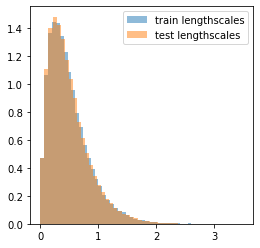

In [121]:
# check distribution of alpha in training and test data
length_train = train_ds.length
length_test = test_ds.length
plt.hist(length_train, density=True, alpha=0.5, bins=50, label='train lengthscales') 
plt.hist(length_test, density=True, alpha=0.5, bins=50, label='test lengthscales') 
# plt.xlim(0,1)
plt.legend()
plt.show()

## CVAE architecture

In [122]:
class Encoder(nn.Module):
    ''' This the encoder part of CVAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim, conditional):
        super().__init__()
        self.conditional = conditional
        if self.conditional:
            input_dim = input_dim + 1
        
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.sd = nn.Linear(hidden_dim, z_dim)
        
    def forward(self, x, c=None):
        if self.conditional:
            #c = c[:, None]
            x = torch.cat((x, c), dim=-1)

        hidden = torch.relu(self.linear(x))
        z_mu = self.mu(hidden)
        z_sd = self.sd(hidden)
        return z_mu, z_sd

In [123]:
class Decoder(nn.Module):
    ''' This the decoder part of VAE
    '''
    def __init__(self,z_dim, hidden_dim, input_dim,  conditional):
        super().__init__()
        
        self.conditional = conditional
        if self.conditional:
            z_dim = z_dim + 1
            
        self.linear = nn.Linear(z_dim, hidden_dim)
        self.out = nn.Linear(hidden_dim, input_dim)
    
    def forward(self, z, c):
        if self.conditional:
            z = torch.cat((z, c), dim=-1)

        hidden = torch.relu(self.linear(z))
        pred = self.out(hidden)
        return pred

In [124]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.
    '''
    def __init__(self, input_dim, hidden_dim, latent_dim,
                 conditional=False):
        
        super().__init__()        
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim, conditional) 
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, conditional)

    def reparameterize(self, z_mu, z_sd):
        '''During training random sample from the learned ZDIMS-dimensional
           normal distribution; during inference its mean.
        '''
        if self.training:
            std = torch.exp(z_sd / 2)
            eps = torch.randn_like(std)
            return (eps.mul(std).add_(z_mu))
        else:
            return z_mu

    def forward(self, x, c=None):
        z_mu, z_sd = self.encoder(x, c)
        x_sample = self.reparameterize(z_mu, z_sd)
        generated_x = self.decoder(x_sample, c)
        return generated_x, z_mu,z_sd

## Train PriorCVAE

In [125]:
# create WandB run
wandb.init(project="cvae-Zimbabe", config=config)
#config = wandb.config

In [126]:
config

{'conditional': True,
 'input_dim': 63,
 'hidden_dim': 63,
 'z_dim': 50,
 'samples': 100000,
 'vae_sd': 0.8,
 'n_epochs': 10000,
 'batch_size': 1000,
 'learning_rate': 0.001}

In [127]:
#def calculate_loss(y, reconstructed_y, mean, log_sd, vae_sd=args["vae_sd"]):
def calculate_loss(y, reconstructed_y, mean, log_sd, vae_sd = config["vae_sd"]):

    # Compute the negative log-likelihood of the Gaussian distribution
    RCL = -torch.sum(- 0.5 * ((y - reconstructed_y) / vae_sd) ** 2)

    # Compute the KL divergence
    KLD = -0.5 * torch.sum(1 + log_sd - mean.pow(2) - log_sd.exp())

    return RCL + KLD

In [128]:
# 1) Model

#input_dim = args["input_dim"]
#hidden_dim = args["hidden_dim"]
#z_dim = args["z_dim"]
#conditional = args["conditional"]

input_dim = config["input_dim"]
hidden_dim = config["hidden_dim"]
z_dim = config["z_dim"]
conditional = config["conditional"]

model = VAE(input_dim, hidden_dim, z_dim, conditional)

# 2) optimizer
optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"])       
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
model = model.to(device)

loss_history_train = []
loss_history_test = []


In [129]:
def calc_loss(model, data, loss_fn):
    
    model.eval()
    with torch.no_grad():
        total_loss = 0

        for i, (y, alpha) in enumerate(data):    
            y = y.to(device)
            if config["conditional"]:
                alpha = alpha.to(device)
                reconstructed_y, z_mu, z_sd = model(y, alpha) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            loss_i = loss_fn(y, reconstructed_y, z_mu, z_sd) 
            total_loss += loss_i.item()
            
    return total_loss / len(data)

In [130]:
#num_epochs = args['n_epochs']
#samples = args['samples']

num_epochs = config["n_epochs"]

samples = config["samples"]

best_model = model

if args["train_vae"] == True:
    
    start_time = time.time()

    for epoch in range(num_epochs):
        
        # Set the model back to training mode
        model.train(True)
        
        # batch training
        for i, (y, length) in enumerate(train_dl):

            # Clear the gradients
            optimizer.zero_grad()
            
            # Forward pass
            y = y.to(device)

            #if args["conditional"]:
            if config["conditional"]:
                length = length.to(device)
                reconstructed_y, z_mu, z_sd = model(y, length) 
            else:
                reconstructed_y, z_mu, z_sd = model(y)
                
            # training loss on the batch    
            loss_tr = calculate_loss(y, reconstructed_y, z_mu, z_sd) 
            
            # Backward pass
            loss_tr.backward()
    
            # Update the weights
            optimizer.step()
            
        # Calculate the training loss for the epoch
        train_loss = calc_loss(model, train_dl, calculate_loss)
        loss_history_train.append(train_loss)
        
        # Set the model to evaluation mode
        model.eval()
  
        # Calculate the test loss for the epoch
        test_loss = calc_loss(model, test_dl, calculate_loss)
        loss_history_test.append(test_loss)
        
        if epoch==0:
            best_loss = test_loss
        else:
            if test_loss < best_loss:
                best_model = model
                best_loss = test_loss
        
        # Print loss
        if args["print_loss"] == True:
            print(f"Epoch {epoch}: Train loss = {train_loss:.4f}, Test loss = {test_loss:.4f}")
            #print(f"Epoch {epoch}: Train loss = {train_loss/(samples*input_dim):.4}, Test loss = {test_loss/(samples*input_dim):.4}")
            
        # log results
        wandb.log({'epoch': epoch, 'train_loss': train_loss, 'test_loss': test_loss})
            
    end_time = time.time()
    t_elapsed = end_time - start_time
    
    # Print elapsed time
    print(f"Elapsed time = {t_elapsed:.4f}")

    plt.figure()
    plt.plot(np.arange(len(loss_history_train)), loss_history_train, label="train loss")
    plt.plot(np.arange(len(loss_history_test)), loss_history_test, label="test loss")
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    plt.title("Train and test loss, PriorCVAE")
    plt.show()

In [131]:
wandb.finish()

In [132]:
if args["train_vae"] == True:
    # Print elapsed time
    print(f"Elapsed time = {t_elapsed:.4f} s")
    print(f"Elapsed time = {t_elapsed/60:.4f} min")
    print(f"Elapsed time = {t_elapsed/(60*60):.4f} h")

In [133]:
args["save_vae"]

False

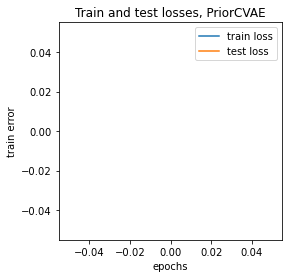

In [134]:
# plot the latest epochs 

start_ind = 20

plt.figure()
plt.plot(np.arange(len(loss_history_train[start_ind:])), loss_history_train[start_ind:], label="train loss")
plt.plot(np.arange(len(loss_history_test[start_ind:])), loss_history_test[start_ind:], label="test loss")
plt.xlabel("epochs")
plt.ylabel("train error")
plt.legend()
plt.title("Train and test losses, PriorCVAE")
plt.show()

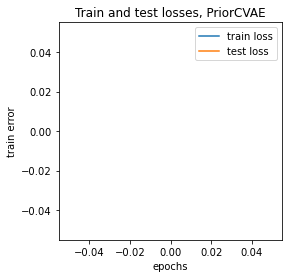

In [135]:
# plot the latest epochs 

start_ind = 5000

plt.figure()
plt.plot(np.arange(len(loss_history_train[start_ind:])), loss_history_train[start_ind:], label="train loss")
plt.plot(np.arange(len(loss_history_test[start_ind:])), loss_history_test[start_ind:], label="test loss")
plt.xlabel("epochs")
plt.ylabel("train error")
plt.legend()
plt.title("Train and test losses, PriorCVAE")
plt.show()

In [136]:
model.state_dict()['encoder.linear.weight'] == best_model.state_dict()['encoder.linear.weight']

tensor([[True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        ...,
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True],
        [True, True, True,  ..., True, True, True]])

In [137]:
model = best_model
del best_model

In [138]:
config["vae_sd"]

0.8

In [139]:
loss_history_train= np.repeat(0, 10000)

In [140]:
import pickle

model_save_name = 'PriorCVAE_Zimbabwe_n'+str(config["input_dim"])+'_h'+str(config["hidden_dim"])+ \
                  '_z'+str(config["z_dim"])+'_epochs'+str(len(loss_history_train))+\
                  '_b'+str(config["batch_size"]) + '_sd' + str(round(config["vae_sd"]*100)) + 'gp.pt'

loss_train_name = 'PriorCVAE_Zimbabwe_n'+str(config["input_dim"])+'_h'+str(config["hidden_dim"])+  \
                  '_z'+str(config["z_dim"])+'_epochs'+str(len(loss_history_train))+ \
                  '_b'+str(config["batch_size"]) + '_sd' + str(round(config["vae_sd"]*100))+'_loss_train_gp'

loss_test_name =  'PriorCVAE_Zimbabwe_n'+str(config["input_dim"])+'_h'+str(config["hidden_dim"])+\
                  '_z'+str(config["z_dim"])+'_epochs'+str(len(loss_history_train))+ \
                  '_b'+str(config["batch_size"]) + '_sd' + str(round(config["vae_sd"]*100))+'_loss_test_gp'

print(model_save_name) 
print(loss_train_name) 
print(loss_test_name) 

PATH = cwd + F"/trained_models/{model_save_name}" 
loss_train_name = cwd +"/trained_models/" + loss_train_name
loss_test_name = cwd + "/trained_models/" + loss_test_name

if args["save_vae"] == True:    
    print("VAE model saved")
    torch.save(model.state_dict(), PATH)
    
    with open(loss_train_name, "wb") as fp:  
        pickle.dump(loss_history_train, fp)
    with open(loss_test_name, "wb") as fp:  
        pickle.dump(loss_history_test, fp)
        
elif args["load_vae"] == True:
    model.load_state_dict(torch.load(PATH))
    
    with open(loss_train_name, "rb") as fp:   
        loss_history_train = pickle.load(fp)
    with open(loss_test_name, "rb") as fp:   
        loss_history_test = pickle.load(fp)

    print("CVAE model loaded")
else:
    print("no model loaded")

PriorCVAE_Zimbabwe_n63_h63_z50_epochs10000_b1000_sd80gp.pt
PriorCVAE_Zimbabwe_n63_h63_z50_epochs10000_b1000_sd80_loss_train_gp
PriorCVAE_Zimbabwe_n63_h63_z50_epochs10000_b1000_sd80_loss_test_gp
CVAE model loaded


## Plot what VAE has learnt - TO DO

In [141]:
N = s.shape[0]

In [142]:
# decoder parameters

model = model.to('cpu')
decoder_dict = model.decoder.state_dict()
decoder_dict.keys()

W1 = decoder_dict['linear.weight'].T.numpy()
B1 = decoder_dict['linear.bias'].numpy()
W2 = decoder_dict['out.weight'].T.numpy()
B2 = decoder_dict['out.bias'].T.numpy()

print(W1.shape)
print(B1.shape)
print(W2.shape)
print(B2.shape)

(51, 63)
(63,)
(63, 63)
(63,)


In [143]:
def c_decoder_numpy(z, W1, B1, W2, B2, c=None):
   
    def linear(z, W, B):
        lin_out = jnp.matmul(z, W) + B
        return lin_out

    if c is not None:
        c = jnp.array(c).reshape(1)
        z = jnp.concatenate([z, c], axis=0)

    hidden = jax.nn.relu(linear(z, W1, B1))
    out = linear(hidden, W2, B2)
    return out

In [144]:
def model_CVAE_draws(c=None):
    
    if c is None and conditional==True:
        c = numpyro.sample("c", npdist.Gamma(2,4)) 
        
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim))) 
    gp_std_vae = numpyro.deterministic("vae_gp_std", c_decoder_numpy(z, W1, B1, W2, B2, c))

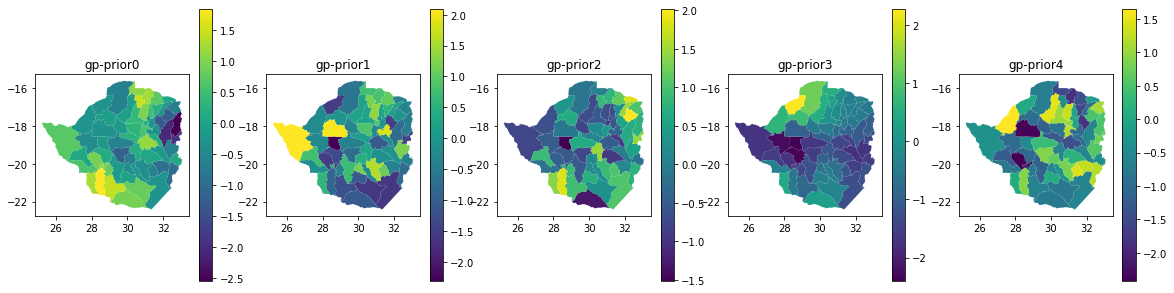

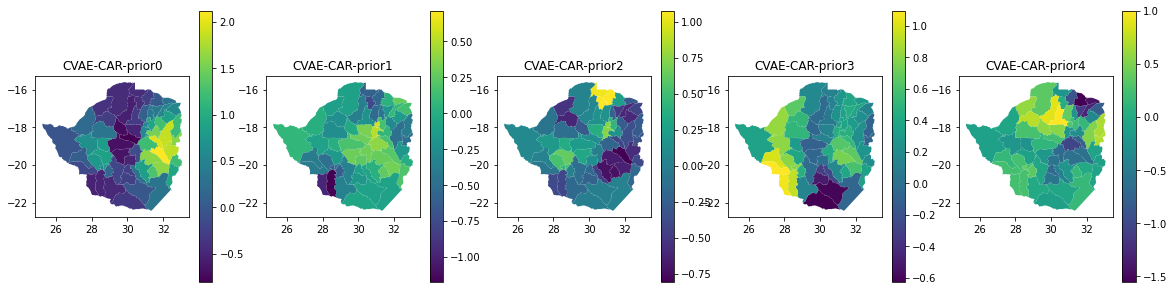

In [145]:
n_samps = 100

# gp: prior predictive
rng_key, rng_key_ = random.split(random.PRNGKey(4))
gp_predictive = Predictive(model_gp_draws, num_samples=n_samps)
gp_preds = gp_predictive(rng_key_, x=jnp.array(coords))
gp_draws = gp_preds['re_std']

s_plot = s.copy()
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'gp_draw_' + str(i)
    s_plot[nm] = gp_draws[i,:]
    s_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'gp-prior' + str(i))

# VAE-CAR: prior predictive
rng_key, rng_key_ = random.split(random.PRNGKey(4))
vae_predictive = Predictive(model_CVAE_draws, num_samples=n_samps)
vae_preds = vae_predictive(rng_key_)
vae_draws = vae_preds['vae_gp_std']

s_plot = s.copy()
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i in range(5):
    nm = 'car_draw_' + str(i)
    s_plot[nm] = vae_draws[i,:]
    s_plot.plot(column=nm, ax=axs[i], legend=True)
    axs[i].set_title( 'CVAE-CAR-prior' + str(i))

In [146]:
gp_draws.shape

(100, 63)

In [147]:
vae_draws.shape

(100, 63)

In [148]:
gp_draws_mean = gp_draws.mean(axis=0)
gp_draws_25 = np.quantile(gp_draws, 0.25, axis=0)
gp_draws_75 = np.quantile(gp_draws, 0.75, axis=0)

vae_draws_mean = vae_draws.mean(axis=0)
vae_draws_25 = np.quantile(vae_draws, 0.25, axis=0)
vae_draws_75 = np.quantile(vae_draws, 0.75, axis=0)

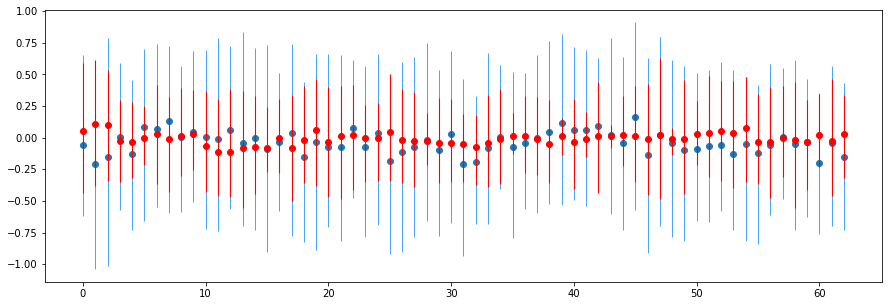

In [149]:
fig, axs = plt.subplots(1, 1, figsize=(15, 5))

plt.scatter(np.arange(len(gp_draws_mean)), gp_draws_mean)
plt.scatter(np.arange(len(gp_draws_mean)), vae_draws_mean, color="red")

plt.vlines(x=np.arange(len(gp_draws_mean)), 
           ymin=gp_draws_25,
           ymax=gp_draws_75,
           color="dodgerblue", 
           label="GP", 
           linewidth=0.8)

plt.vlines(x=np.arange(len(vae_draws_mean)), 
           ymin=vae_draws_25,
           ymax=vae_draws_75,
           color="red", 
           label="VAE", 
           linewidth=1.1)

In [150]:
def MMD(x, y, kernel="multiscale"):
    """Emprical maximum mean discrepancy. The lower the result, the more evidence that distributions are the same.

    Args:
        x: first sample, distribution P
        y: second sample, distribution Q
        kernel: kernel type such as "multiscale" or "rbf"
    """
    xx, yy, zz = torch.mm(x, x.t()), torch.mm(y, y.t()), torch.mm(x, y.t())
    rx = (xx.diag().unsqueeze(0).expand_as(xx))
    ry = (yy.diag().unsqueeze(0).expand_as(yy))
    
    dxx = rx.t() + rx - 2. * xx # Used for A in (1)
    dyy = ry.t() + ry - 2. * yy # Used for B in (1)
    dxy = rx.t() + ry - 2. * zz # Used for C in (1)
    
    XX, YY, XY = (torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device),
                  torch.zeros(xx.shape).to(device))
    
    if kernel == "multiscale":
        
        bandwidth_range = [0.2, 0.5, 0.9, 1.3]
        for a in bandwidth_range:
            XX += a**2 * (a**2 + dxx)**-1
            YY += a**2 * (a**2 + dyy)**-1
            XY += a**2 * (a**2 + dxy)**-1
            
    if kernel == "rbf":

        bandwidth_range = [10, 15, 20, 50]
        for a in bandwidth_range:
            XX += torch.exp(-0.5*dxx/a)
            YY += torch.exp(-0.5*dyy/a)
            XY += torch.exp(-0.5*dxy/a)
      
    return torch.mean(XX + YY - 2. * XY)

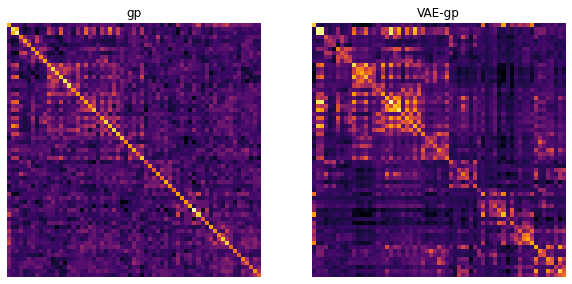

Frobenius norm = 8.08893647434008
MMD, multiscale = tensor(0.1070)
MMD, rbf = tensor(0.4722)


In [151]:
m_gp = np.cov((gp_draws.transpose()))
m_cvae = np.cov((vae_draws.transpose()))

#'plasma'
 #'inferno'
cmap_choice = 'inferno'

fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (10,6))

axs[0].imshow(m_gp, cmap=cmap_choice)
axs[0].axis('off')
axs[0].set_title('gp')

axs[1].imshow(m_cvae, cmap=cmap_choice)
axs[1].axis('off')
axs[1].set_title('VAE-gp')

plt.show()

print('Frobenius norm = ' + str(np.linalg.norm(m_gp - m_cvae,  'fro')))
gg = torch.from_numpy(np.array(gp_draws))
vv = torch.from_numpy(np.array(vae_draws))
print('MMD, multiscale = ' + str(MMD(gg, vv)))
print('MMD, rbf = ' + str(MMD(gg, vv, "rbf")))

## Inference - Prevalence model

In [152]:
def prev_model_VAE(n_obs, c=None, var=1, jitter=1.0e-5, y=None):
    
    # fixed effects
    b0 = numpyro.sample('b0', npdist.Normal(0, 1))
    
    if c==None:  
        c = numpyro.sample("c", npdist.Gamma(2,4)) 
        
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(z_dim), jnp.ones(z_dim))) 
    re_std_vae = numpyro.deterministic("re_std_vae", c_decoder_numpy(z, W1, B1, W2, B2, c))        
    kernel_var = numpyro.sample("kernel_var", npdist.Gamma(1.5, 1.5)) 
    re_vae = numpyro.deterministic('re_vae', kernel_var * re_std_vae)
    
    re0_vae = numpyro.deterministic('RE-VAE 1', re_vae[0])
    
    # linear predictor
    lp = b0 + re_vae
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(lp))
     
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=lp), obs=y)

In [153]:
rng_key, rng_key_predict = random.split(random.PRNGKey(6))

# inference
start = time.time()
kernel = NUTS(prev_model_VAE)
mcmc_vae = MCMC(kernel, num_warmup=args['num_warmup'], num_samples=args['num_samples'], num_chains=args["num_chains"])
mcmc_vae.run(rng_key, n_obs = jnp.array(s.n_obs), y = jnp.array(s.y))
t_elapsed = time.time() - start

prev_samples_vae = mcmc_vae.get_samples()
#mcmc_vae.print_summary()

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

In [154]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")
ss = numpyro.diagnostics.summary(mcmc_vae.get_samples(group_by_chain=True))
r = np.mean(ss['re_vae']['n_eff'])
print("Average ESS for all VAE-CAR effects : " + str(round(r)))


MCMC elapsed time: 7 s
Average ESS for all VAE-CAR effects : 5073


In [155]:
mcmc_vae.print_summary(exclude_deterministic=False)


                    mean       std    median      5.0%     95.0%     n_eff     r_hat
      RE-VAE 1      0.30      0.16      0.30      0.04      0.55   4388.98      1.00
            b0     -1.80      0.15     -1.81     -2.05     -1.57   3991.50      1.00
             c      1.12      0.25      1.06      0.73      1.49   6419.31      1.00
    kernel_var      0.48      0.12      0.46      0.30      0.65   5079.32      1.00
 re_std_vae[0]      0.67      0.37      0.66      0.07      1.27   4210.10      1.00
 re_std_vae[1]      0.03      0.33      0.03     -0.52      0.56   4727.75      1.00
 re_std_vae[2]     -0.00      0.33     -0.00     -0.55      0.54   4607.16      1.00
 re_std_vae[3]     -0.77      0.40     -0.76     -1.45     -0.14   4906.51      1.00
 re_std_vae[4]     -0.85      0.39     -0.83     -1.47     -0.20   5301.11      1.00
 re_std_vae[5]     -0.52      0.37     -0.51     -1.13      0.07   5359.83      1.00
 re_std_vae[6]     -0.57      0.39     -0.56     -1.20      0.06

In [156]:
mcmc_vae_samples = mcmc_vae.get_samples()
c_samps_vae = mcmc_vae_samples['c']

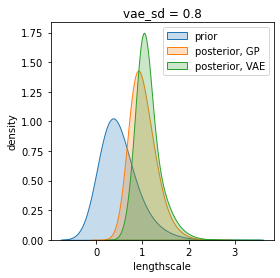

In [157]:
bw = 4
sns.kdeplot(ls_prior_draws, bw_adjust= bw, shade = True, label='prior')
sns.kdeplot(c_samps_gp, bw_adjust= bw, shade = True, label='posterior, GP')
sns.kdeplot(c_samps_vae, bw_adjust= bw, shade = True, label='posterior, VAE')
plt.xlabel('lengthscale')
plt.ylabel('density')
plt.title('vae_sd = ' + str(config["vae_sd"]))
plt.legend()

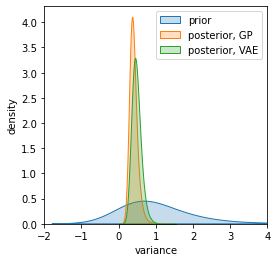

In [158]:
var_samps_gp = mcmc_gp_samples['kernel_var']
var_samps_vae = mcmc_vae_samples['kernel_var']
#plt.hist(var_samps_vae, density=True, label = 'posterior samples, VAE', bins=40, alpha=0.5)
#plt.hist(var_samps_gp, density=True, label = 'posterior samples, GP', bins=40, alpha=0.5)


bw = 4
sns.kdeplot(kernel_var_prior, bw_adjust= bw, shade = True, label='prior')
sns.kdeplot(var_samps_gp, bw_adjust= bw, shade = True, label='posterior, GP')
sns.kdeplot(var_samps_vae, bw_adjust= bw, shade = True, label='posterior, VAE')
plt.xlabel('variance')
plt.ylabel('density')
plt.xlim(-2,4)
plt.legend()

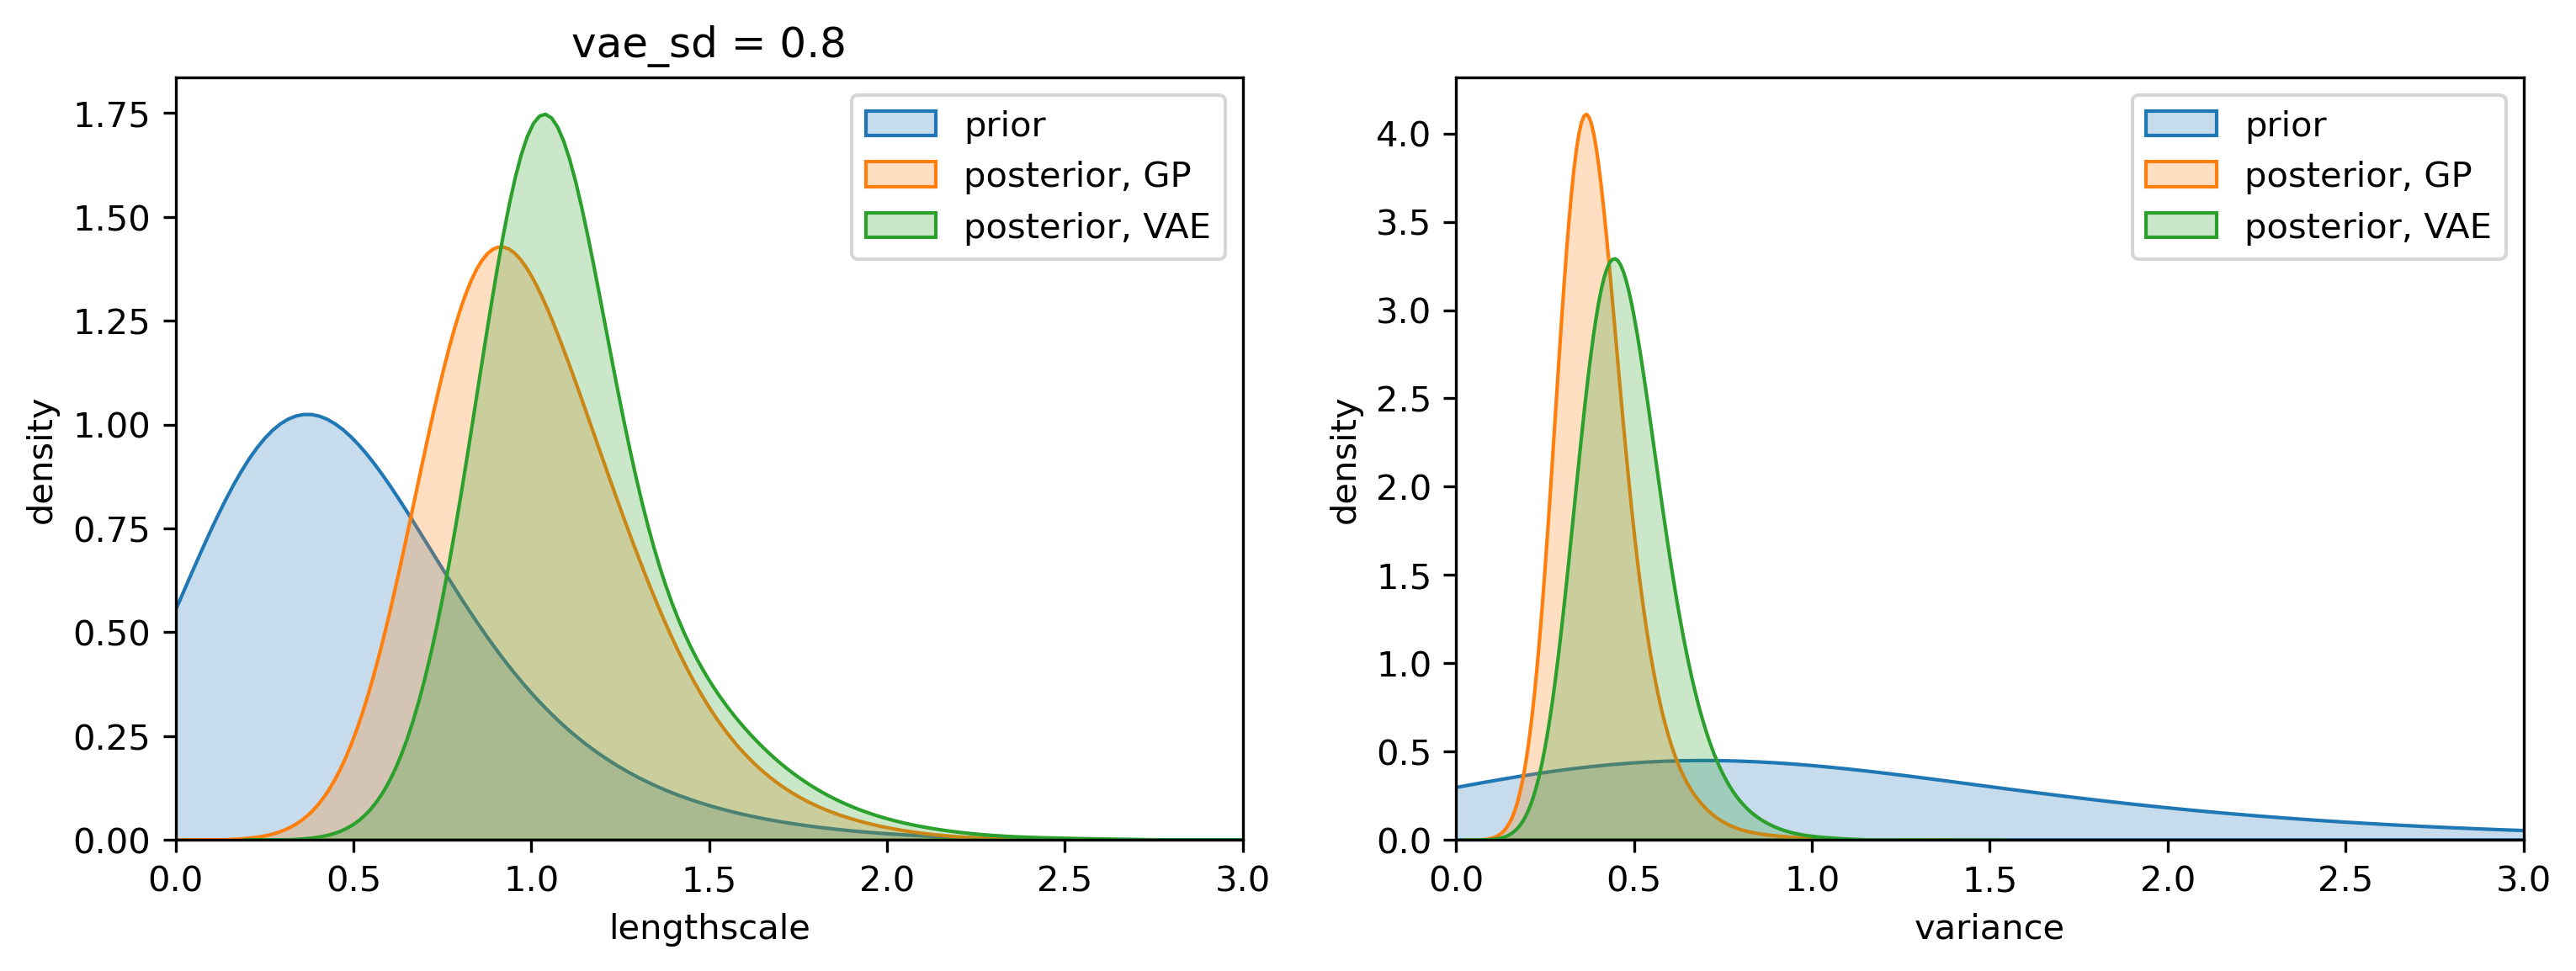

In [185]:
#fig, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,6))

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

bw_ls = 4
sns.kdeplot(ls_prior_draws, bw_adjust= bw_ls, shade = True, label='prior', ax=axs[0])
sns.kdeplot(c_samps_gp, bw_adjust= bw_ls, shade = True, label='posterior, GP', ax=axs[0])
sns.kdeplot(c_samps_vae, bw_adjust= bw_ls, shade = True, label='posterior, VAE', ax=axs[0])
axs[0].set_xlabel('lengthscale')
axs[0].set_ylabel('density')
axs[0].set_title('vae_sd = ' + str(config["vae_sd"]))
axs[0].set_xlim(0,3)
axs[0].legend()

bw_var = 4
sns.kdeplot(kernel_var_prior, bw_adjust= bw_var, shade = True, label='prior', ax=axs[1])
sns.kdeplot(var_samps_gp, bw_adjust= bw_var, shade = True, label='posterior, GP', ax=axs[1])
sns.kdeplot(var_samps_vae, bw_adjust= bw_var, shade = True, label='posterior, VAE', ax=axs[1])
axs[1].set_xlabel('variance')
axs[1].set_ylabel('density')
axs[1].set_xlim(0,3)
#axs[1].set_title('vae_sd = ' + str(config["vae_sd"]))
axs[1].legend()

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#plt.savefig('res/Zimbabwe_estimates_vaeSd{}.pdf'.format(config["vae_sd"]))

In [163]:
import arviz as az

array([[<AxesSubplot: title={'center': 'c'}>,
        <AxesSubplot: title={'center': 'c'}>]], dtype=object)

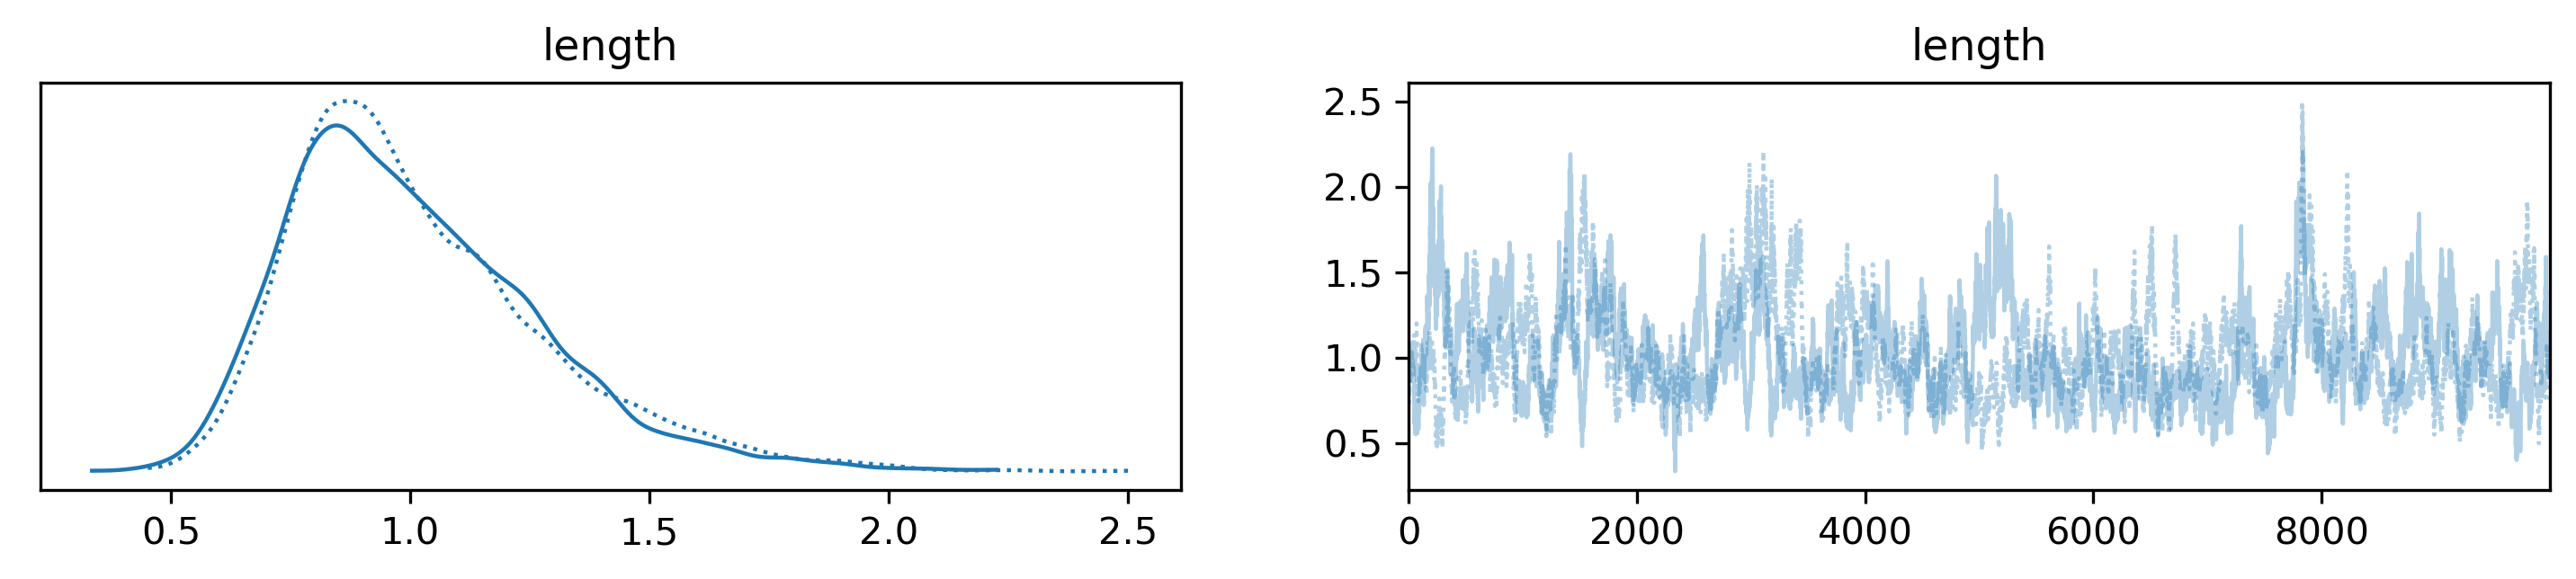

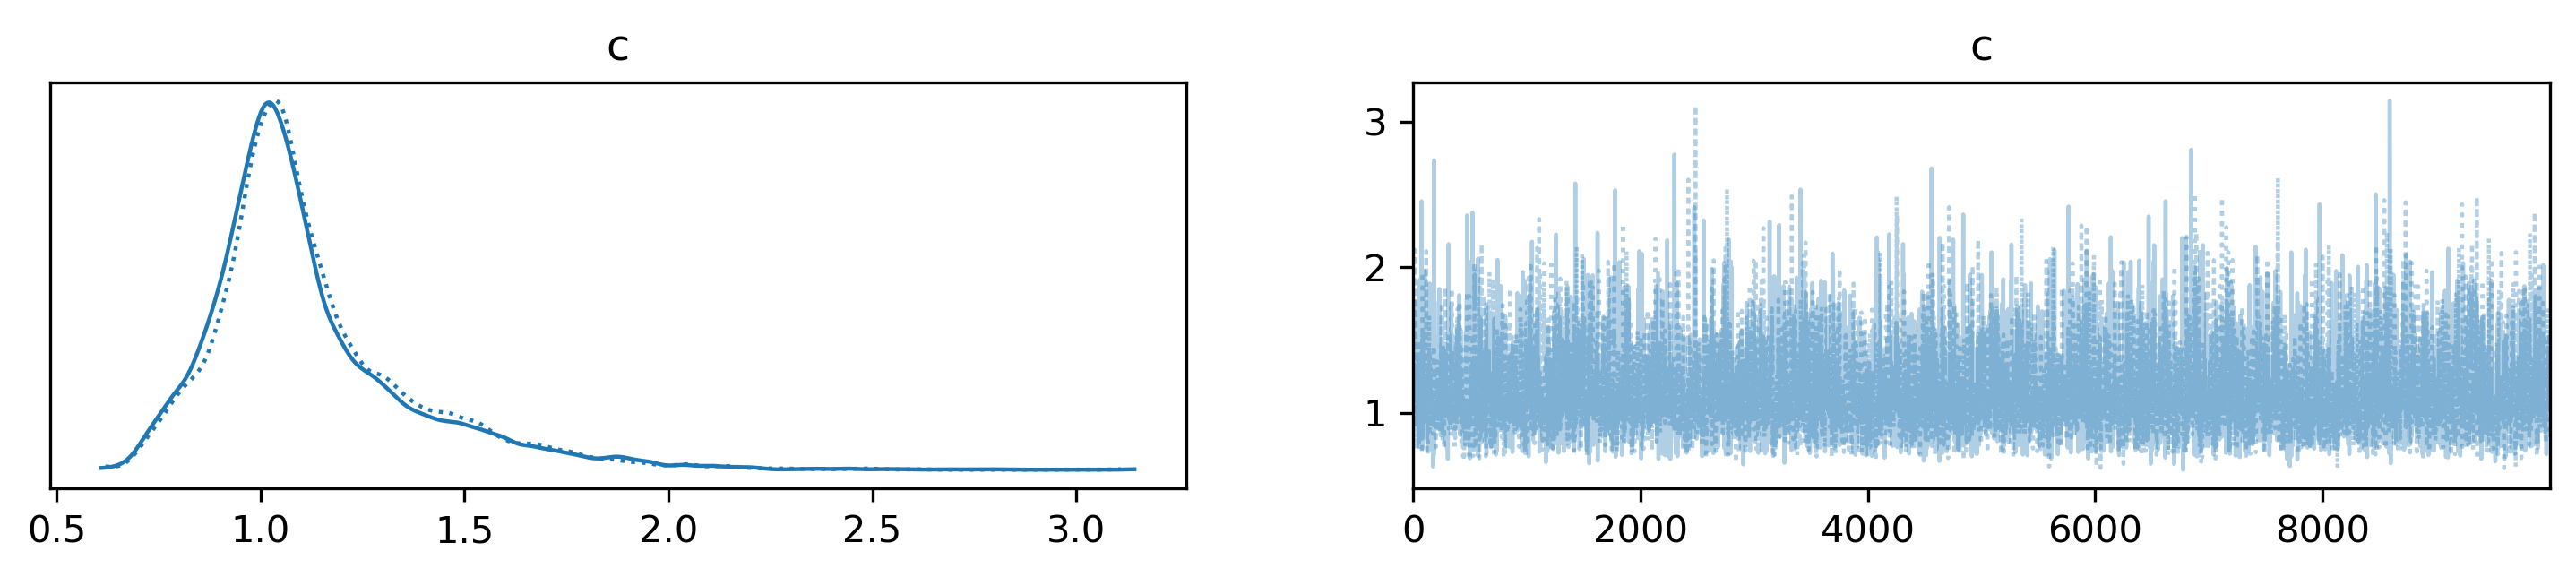

In [164]:
prev_samples_vae_az = az.from_numpyro(mcmc_vae)
prev_samples_gp_az = az.from_numpyro(mcmc_gp)
#az.plot_trace(prev_samples_car_az,  var_names=("CAR 1"))
#az.plot_trace(prev_samples_vae_az,  var_names=("VAE-CAR 1"))
az.plot_trace(prev_samples_gp_az,  var_names=("length"))
az.plot_trace(prev_samples_vae_az,  var_names=("c"))

Text(0.5, 1.0, 'Estimated prevalence (VAE)')

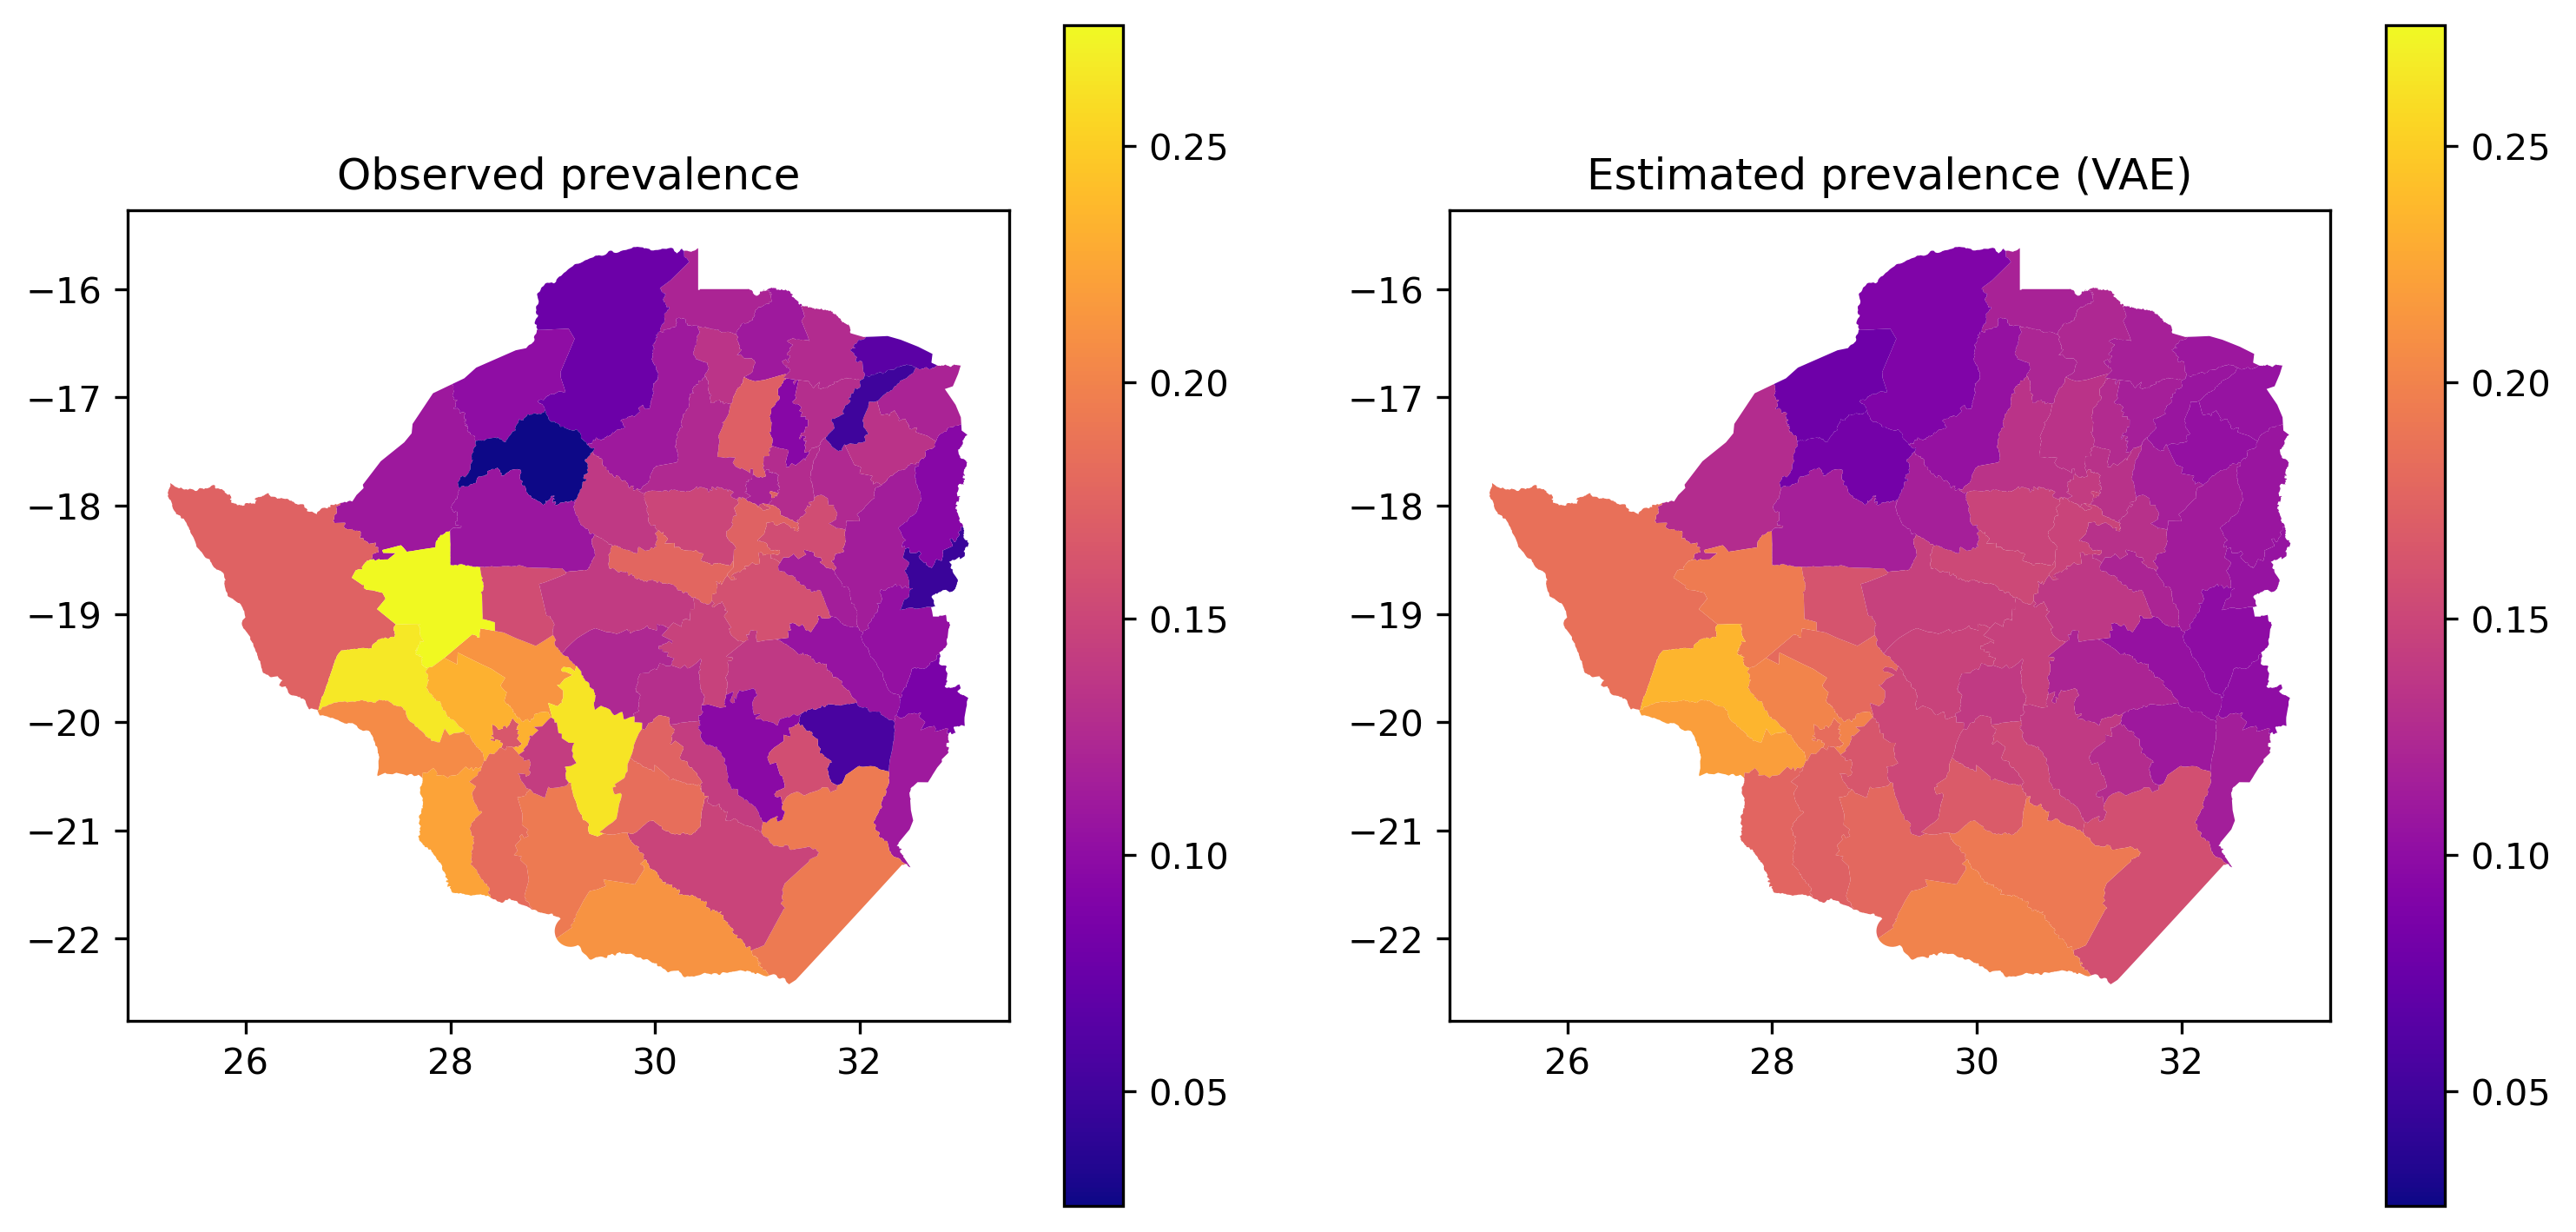

In [165]:
# posterior predictive
prev_posterior_predictive_vae = Predictive(prev_model_VAE, prev_samples_vae)(random.PRNGKey(1), n_obs = jnp.array(s.n_obs))

theta_samps_vae = prev_posterior_predictive_vae['theta']
theta_mean_vae = theta_samps_vae.mean(axis=0)
bci_vae_25 = np.quantile(theta_samps_vae, 0.25, axis=0)
bci_vae_75 = np.quantile(theta_samps_vae, 0.75, axis=0)

s['theta_vae'] = theta_mean_vae

theta_observed = s['estimate']
theta_estimated_vae = s['theta_vae']

_max = np.max([theta_observed, theta_estimated_vae])
_min = np.min([theta_observed, theta_estimated_vae])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
s.plot(column="estimate", ax=ax[0], legend=True, cmap='plasma', vmin=_min, vmax =_max)
s.plot(column="theta_vae", ax=ax[1], legend=True, cmap='plasma', vmin=_min, vmax =_max)
ax[0].set_title( 'Observed prevalence')
ax[1].set_title( 'Estimated prevalence (VAE)')

Text(0, 0.5, 'VAE estimated theta')

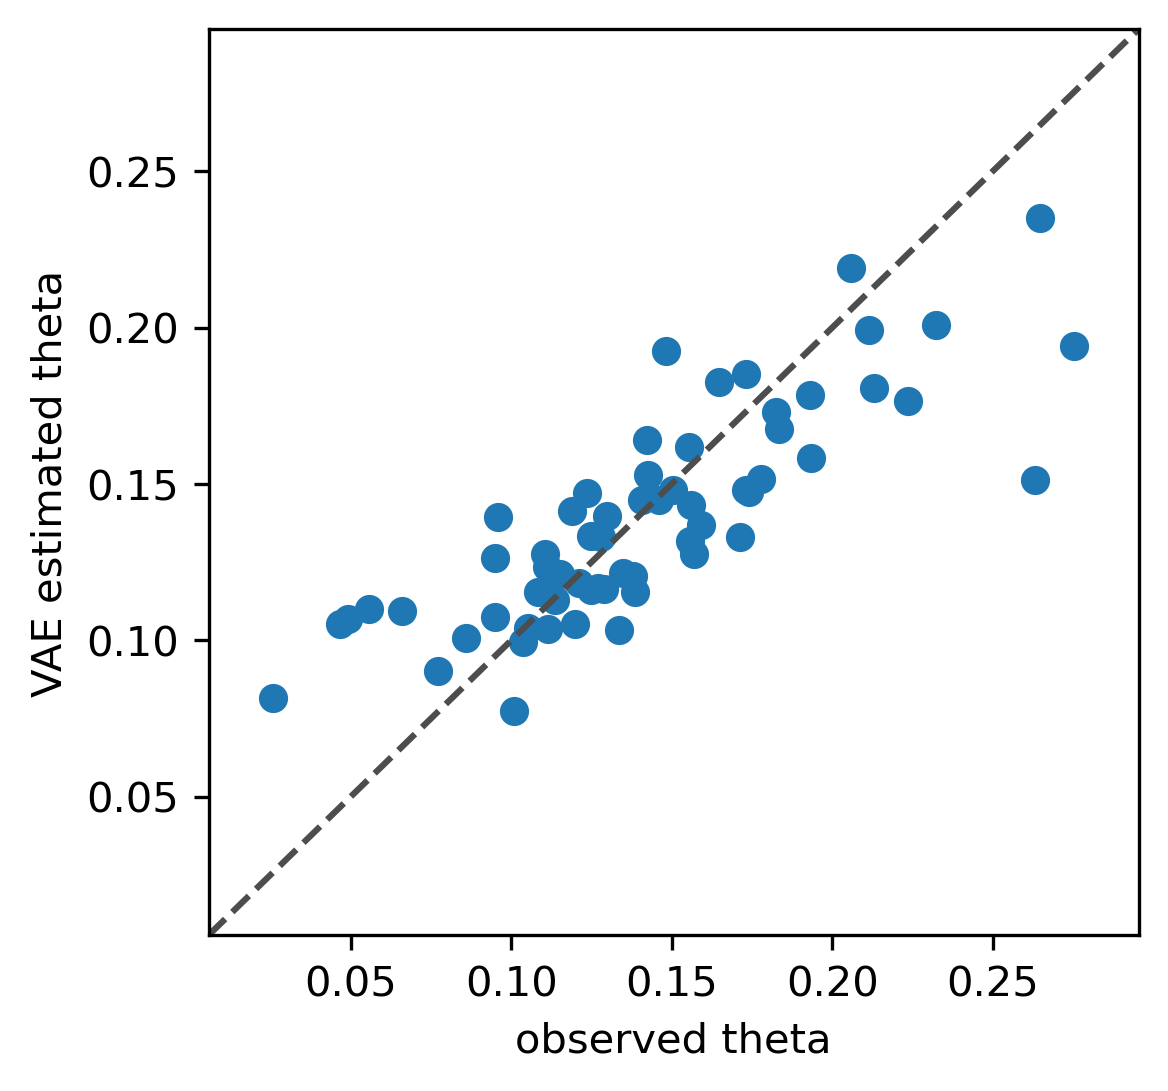

In [166]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(theta_observed, theta_estimated_vae)
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("observed theta")
plt.ylabel("VAE estimated theta")

In [167]:
vaecar0_samps = prev_posterior_predictive_vae['VAE-CAR 1']
n_samps = vaecar0_samps.shape[0]
car0_samps = prev_posterior_predictive['CAR 1']
n_samps = car0_samps.shape[0]

import pandas as pd
df_plt = pd.DataFrame({'VAE-CAR': vaecar0_samps, 'CAR': car0_samps})
df_plt.head()
df_plt.plot(lw = 0.6, alpha=0.9, figsize=(10, 5))
plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("Parameter estimate")
#plt.show()

KeyError: 'VAE-CAR 1'

In [168]:
s.columns

Index(['area_id', 'geometry', 'y', 'n_obs', 'estimate', 'centroid',
       'prior_theta_mean', 'prior_theta_min', 'prior_theta_max', 'theta_gp',
       'theta_vae'],
      dtype='object')

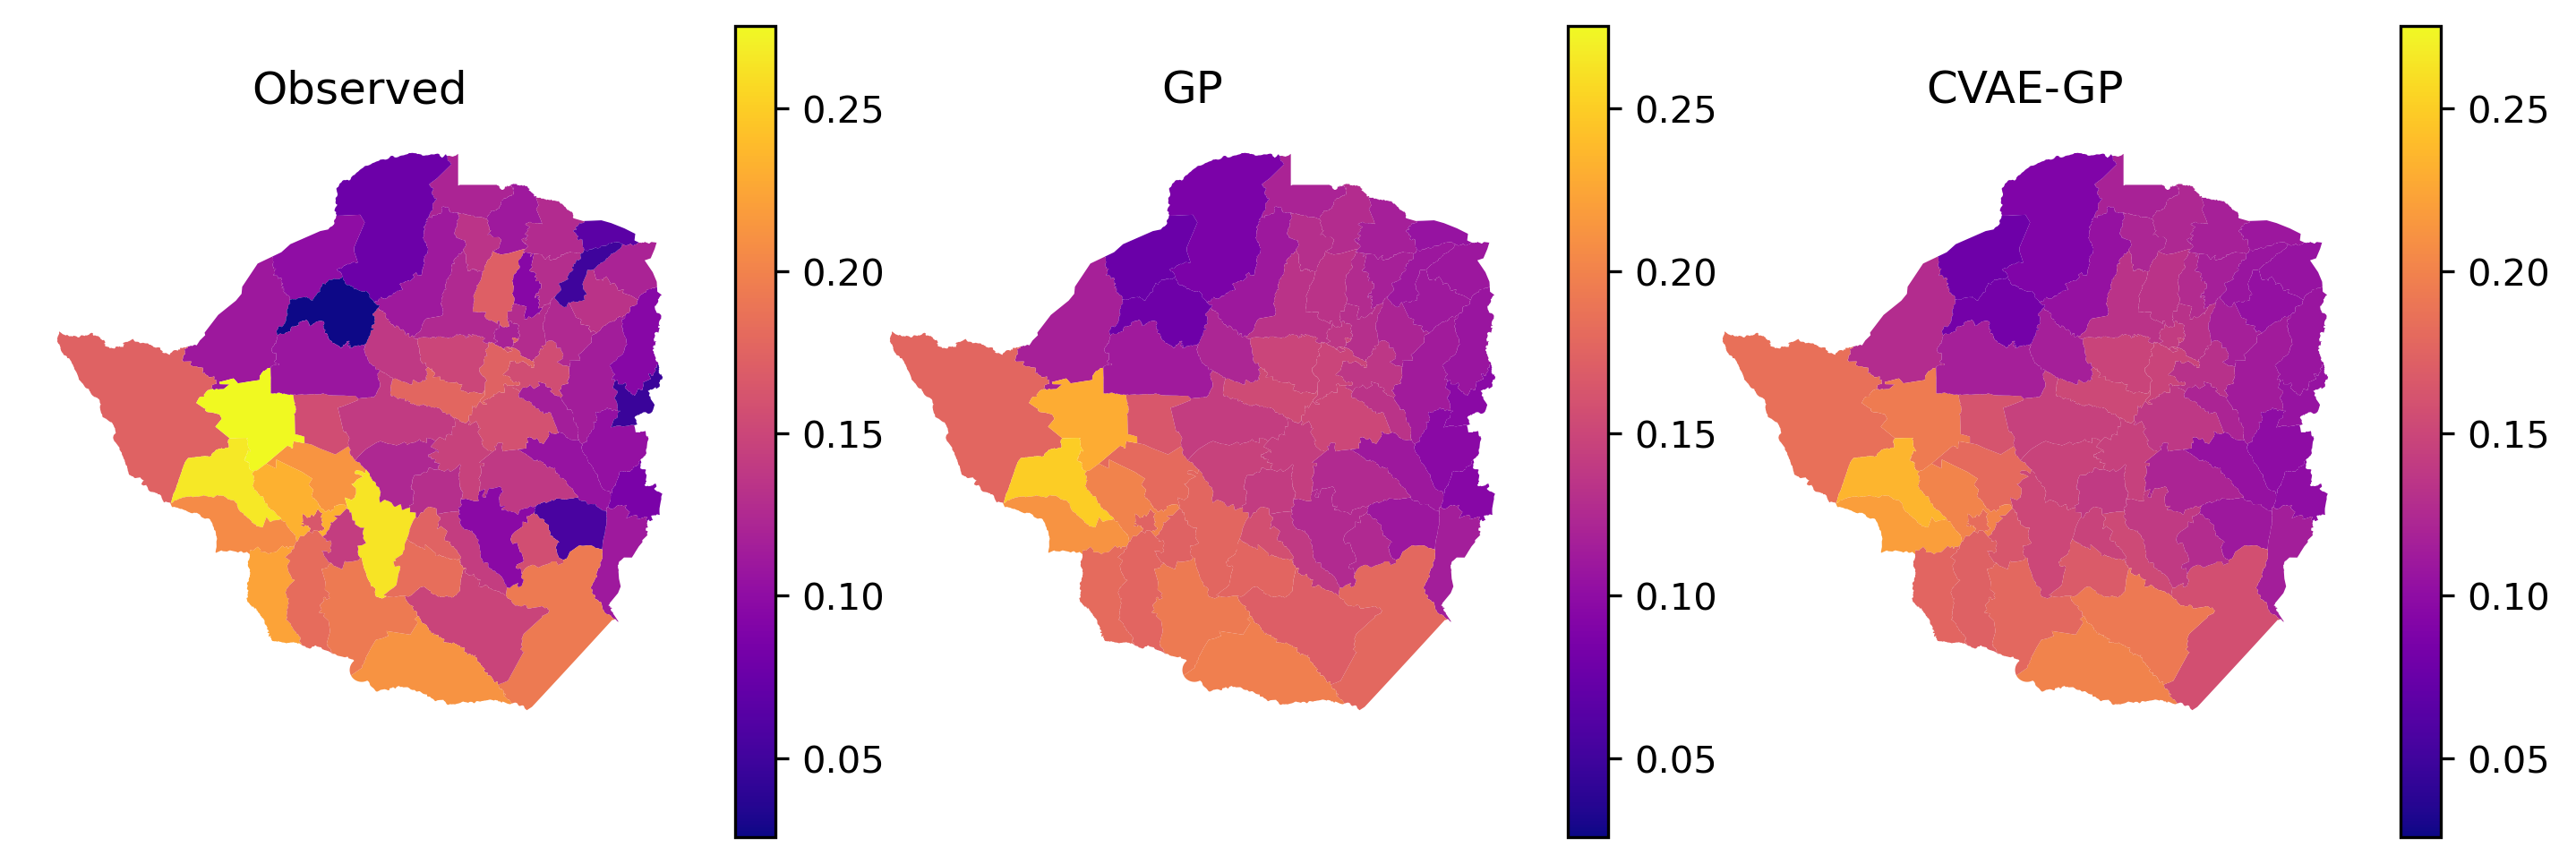

In [175]:
var = ['estimate', 'theta_gp', 'theta_vae']
ttls = ['Observed', 'GP', 'CVAE-GP']

_max = np.max([s['estimate'], s['theta_gp'], s['theta_vae']])
_min = np.min([s['estimate'], s['theta_gp'], s['theta_vae']])

fig, axs = plt.subplots(1, len(var), figsize=(12, 4))

for i in range(len(var)):
    s.plot(column=var[i], ax=axs[i], legend=True, cmap='plasma', vmin=_min, vmax =_max)
    #df.plot(column=var[i], ax=axs[i])
    axs[i].axis('off')
    axs[i].set_title(ttls[i])

fig.subplots_adjust(wspace=0, hspace=0)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/Zimbabwe_maps.pdf')


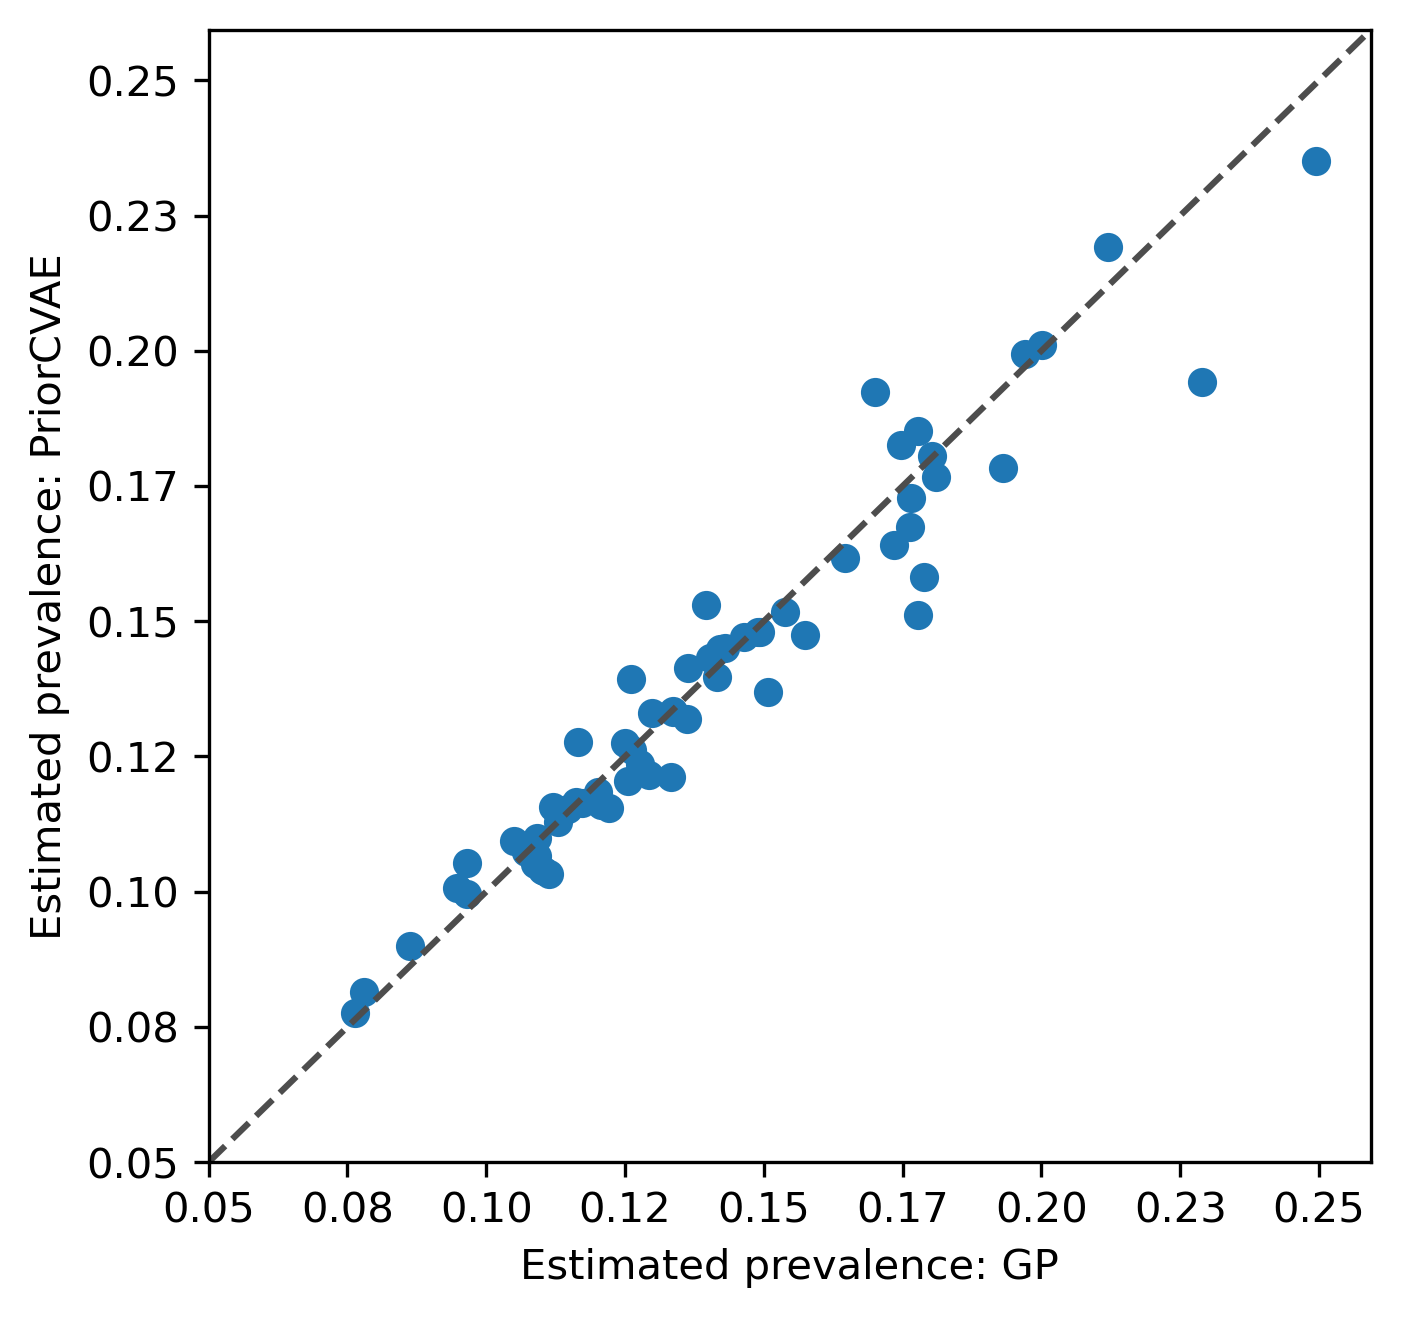

In [184]:
_max = np.max([ s['theta_gp'], s['theta_vae']])
_min = np.min([ s['theta_gp'], s['theta_vae']])

plt.rcParams["figure.figsize"] = (5,5)
from matplotlib.ticker import FormatStrFormatter


fig, ax = plt.subplots()

plt.scatter(s['theta_gp'], s['theta_vae'])
#plt.ylim(_min-0.01, _max+0.01)
plt.ylim(0.05, _max+0.01)
#plt.xlim(_min-0.01, _max+0.01)
plt.xlim(0.05, _max+0.01)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("Estimated prevalence: GP")
plt.ylabel("Estimated prevalence: PriorCVAE")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.savefig('res/Zimbabwe_estimates_prev.pdf')

Text(0, 0.5, 'observed theta')

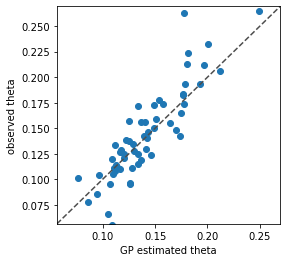

In [91]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_gp'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("GP estimated theta")
plt.ylabel("observed theta")

Text(0, 0.5, 'observed theta')

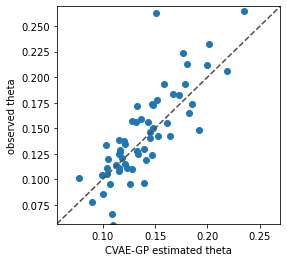

In [92]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(s['theta_vae'], s['estimate'])
plt.ylim(_min-0.02, _max+0.02)
plt.xlim(_min-0.02, _max+0.02)
plt.axline((1, 1), slope=1, ls="--", c=".3")
plt.xlabel("CVAE-GP estimated theta")
plt.ylabel("observed theta")

In [93]:
_max = np.max([ theta_vae_car, theta_mean_car, bci_car_25, bci_car_75, bci_vae_car_25, bci_vae_car_75])
_min = np.min([ theta_mean_vae_car, theta_mean_car])

plt.rcParams["figure.figsize"] = (6,6)

plt.ylim(_min, _max)
plt.xlim(_min, _max)
plt.plot([_min, _max], [_min, _max], ls="--", c=".3")
plt.xlabel("predicted prevalence, VAE-CAR")
plt.ylabel("predicted prevalence, CAR")

plt.vlines(x=theta_mean_car, 
           ymin=bci_car_25,
           ymax=bci_car_75,
           color="orange", 
           label="50% BCI, CAR", 
           linewidth=0.8)
plt.hlines(y=theta_mean_vae_car, 
           xmin=bci_vae_car_25,
           xmax=bci_vae_car_75,
           color="steelblue", 
           label="50% BCI, VAE-CAR", 
           linewidth=0.8)

plt.scatter(theta_mean_vae_car, theta_mean_car, color="teal")
plt.legend(loc="upper left")

NameError: name 'theta_vae_car' is not defined